# Histogram Generator
## Joseph Hickey
## 5/6/2020
## ASTR 400B Project

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib import cm
from SolarTypeDistribution import Distribution
from ReadFile import Read
from matplotlib.colors import LogNorm
from CenterOfMass1 import CenterOfMass1
from CenterOfMass import CenterOfMass
from GalaxyMass import ComponentsMass
import astropy.units as u
import astropy.constants as const

In [2]:
# Read in the data for M31 and generate the mask of particles of interest
t,n,M31start = Read('./snapshots/M31_000.txt')
t,n,M31 = Read('./snapshots/M31_800.txt')
dis = Distribution('./snapshots/M31')
# Finds bound particles at a distance of 8 kpc
mask = dis.Mask(8)

In [3]:
# Converts particle corrdinates and velocities to the center of mass frame
COMstart = CenterOfMass('./snapshots/M31_000.txt',2)
comstartpos = COMstart.COM_P(0.1,4).value
comstartvel = COMstart.COM_V(comstartpos[0],comstartpos[1],comstartpos[2]).value
xstart = M31start['x'][mask] - comstartpos[0]
ystart = M31start['y'][mask] - comstartpos[1]
zstart = M31start['z'][mask] - comstartpos[2]
r = np.sqrt(xstart**2+ystart**2+zstart**2)
vxstart = M31start['vx'][mask] - comstartvel[0]
vystart = M31start['vy'][mask] - comstartvel[1]
vzstart = M31start['vz'][mask] - comstartvel[2]
vel = np.sqrt(vxstart**2+vystart**2+vzstart**2)

In [4]:
# Converts particle corrdinates and velocities to the center of mass frame
COM = CenterOfMass('./snapshots/M31_800.txt',2)
compos = COM.COM_P(0.1,4).value
comvel = COM.COM_V(compos[0],compos[1],compos[2]).value
x = M31['x'][mask] - compos[0]
y = M31['y'][mask] - compos[1]
z = M31['z'][mask] - compos[2]
rnew = np.sqrt(x**2+y**2+z**2)
vx = M31['vx'][mask] - comvel[0]
vy = M31['vy'][mask] - comvel[1]
vz = M31['vz'][mask] - comvel[2]
velnew = np.sqrt(vx**2+vy**2+vz**2)

In [5]:
# Create an array of ratios for histogramming
radiiratio = rnew/r
velratio = velnew/vel

In [6]:
# Create mask to determine the behavior of particles
rlarger = np.where(radiiratio > 1)
rsmaller = np.where(radiiratio < 1)
vlarger = np.where(velratio > 1)
vsmaller = np.where(velratio < 1)

In [7]:
print("The percentage of particles with final radii greater than their initial radii is", np.around(100 * len(radiiratio[rlarger])/len(radiiratio),2))
print("The percentage of particles with final velocities greater than their initial velocities is", np.around(100 * len(velratio[vlarger])/len(velratio),2))

The percentage of particles with final radii greater than their initial radii is 62.62
The percentage of particles with final velocities greater than their initial velocities is 49.18


# Plotting the final outcomes

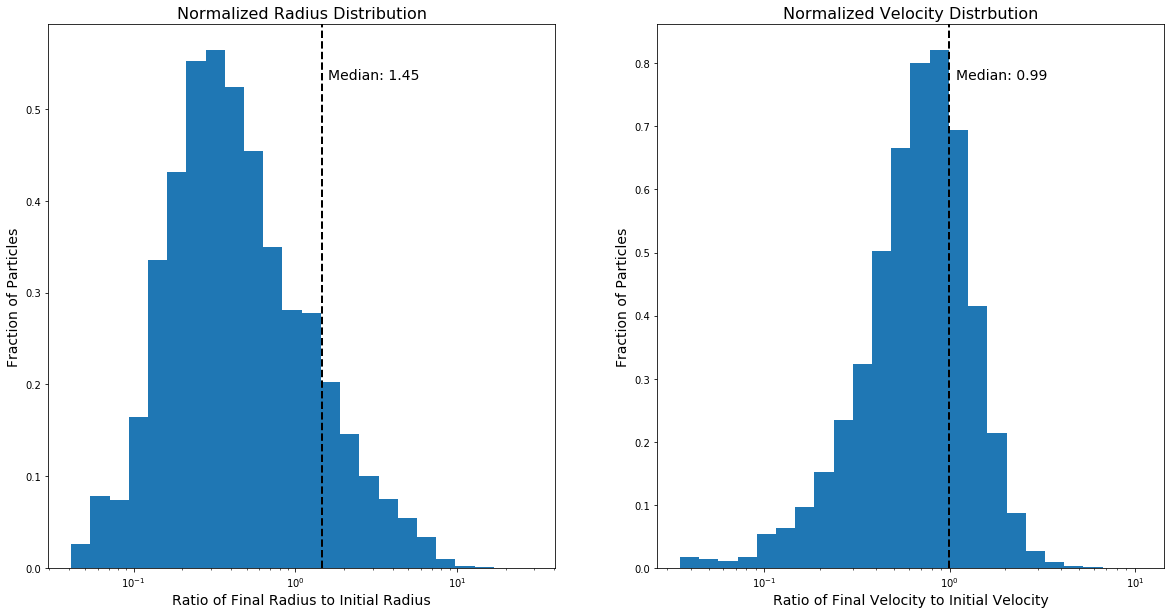

In [8]:
# Create two histograms, one for radii and another for velocities
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
# Set up bins for logarithmic display
rlogbins = np.geomspace(radiiratio.min(), radiiratio.max(), 25)
vlogbins = np.geomspace(velratio.min(), velratio.max(), 25)
# Plot data normalized via the density *farg
ax1.hist(radiiratio,bins=rlogbins,density=True)
ax2.hist(velratio,bins=vlogbins,density=True)


# Label histograms
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_title('Normalized Radius Distribution',fontsize=16)
ax2.set_title('Normalized Velocity Distrbution',fontsize=16)
ax1.set_xlabel('Ratio of Final Radius to Initial Radius',fontsize=14)
ax2.set_xlabel('Ratio of Final Velocity to Initial Velocity',fontsize=14)
ax1.set_ylabel('Fraction of Particles',fontsize=14)
ax2.set_ylabel('Fraction of Particles',fontsize=14)

# Plot and label the median line and save in high resolution
# Median is used to avoid strong outliers which affect the mean value
ax1.axvline(np.median(radiiratio), color='k', linestyle='dashed', linewidth=2)
ax2.axvline(np.median(velratio), color='k', linestyle='dashed', linewidth=2)
a,b = ax1.get_ylim()
c,d = ax2.get_ylim()
ax1.text(np.median(radiiratio)*1.1, b*0.9, 'Median: {:.2f}'.format(np.median(radiiratio)),fontsize=14)
ax2.text(np.median(velratio)*1.1, d*0.9, 'Median: {:.2f}'.format(np.median(velratio)),fontsize=14)
plt.savefig('Histograms.eps',dpi=1000)

In [9]:
# Create arrays of particles which are bound at target radius and particles which are in the disk
M31particles = M31[mask]
disk = np.where(M31['type'] == 2)
M31disk = M31[disk]
M31startdisk = M31start[disk]

# Rotate the frame and plot projections

In [10]:
# Function from an in class lab written by Dr. Gurtina Besla, R. Hoffman, & E. Patel
# Takes advantage of the cartesian coordinates of the data

# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 

def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction

    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [11]:
# Changing entire disk to center of mass frame for plotting consistency
M31x = M31disk['x']-compos[0]
M31y = M31disk['y']-compos[1]
M31z = M31disk['z']-compos[2]
M31startx = M31startdisk['x']-comstartpos[0]
M31starty = M31startdisk['y']-comstartpos[1]
M31startz = M31startdisk['z']-comstartpos[2]
M31vx = M31disk['vx']-comvel[0]
M31vy = M31disk['vy']-comvel[1]
M31vz = M31disk['vz']-comvel[2]
M31startvx = M31startdisk['vx']-comstartvel[0]
M31startvy = M31startdisk['vy']-comstartvel[1]
M31startvz = M31startdisk['vz']-comstartvel[2]

In [12]:
# Massaging the data to fit the function by changing the axis
# Function returns a rotated galaxy with the X-Y projection being face-on
pos = np.transpose(np.array([x,y,z]))
vel = np.transpose(np.array([vx,vy,vz]))
posstart = np.transpose(np.array([xstart,ystart,zstart]))
velstart = np.transpose(np.array([vxstart,vystart,vzstart]))
M31pos = np.transpose(np.array([M31x,M31y,M31z]))
M31vel = np.transpose(np.array([M31vx,M31vy,M31vz]))
M31startpos = np.transpose(np.array([M31startx,M31starty,M31startz]))
M31startvel = np.transpose(np.array([M31startvx,M31startvy,M31startvz]))
pos1,vel1 = RotateFrame(posstart,velstart)
pos2,vel2 = RotateFrame(pos,vel)
M31pos1,M31vel1 = RotateFrame(M31startpos,M31startvel)
M31pos2,M31vel2 = RotateFrame(M31pos,M31vel)

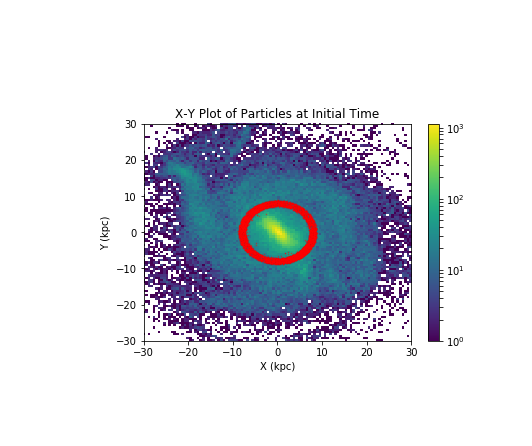

In [13]:
# Overplots particles in initial positions to show a strong band of datapoints
plt.hist2d(M31pos1[:,0],M31pos1[:,1],bins=200,norm=LogNorm())
plt.plot(pos1[:,0],pos1[:,1],'r.',ms=1,alpha=0.5)
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.colorbar()

# Label and save image
plt.title('X-Y Plot of Particles at Initial Time')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.savefig('000.eps',dpi=100,transparent=True)

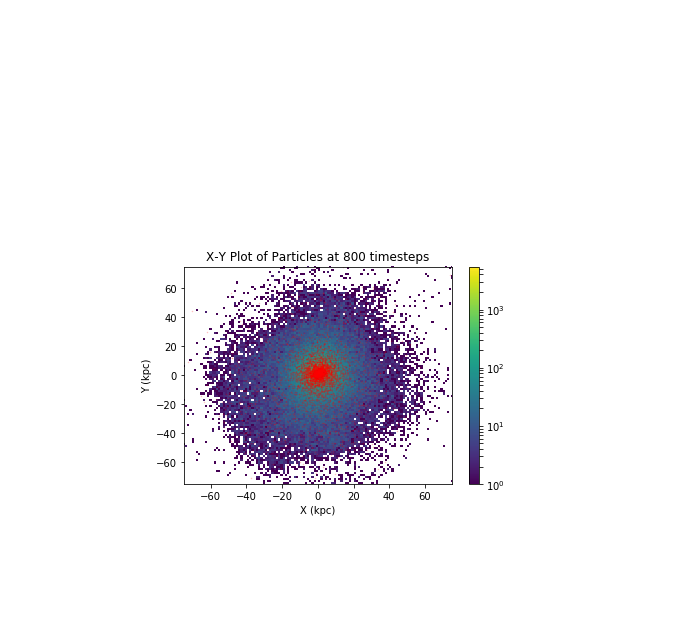

In [14]:
# Overplots particles at final timestep to show the change in density
plt.hist2d(M31pos2[:,0],M31pos2[:,1],bins=300,norm=LogNorm())
plt.plot(pos2[:,0],pos2[:,1],'r.',ms=1,alpha=0.25)
plt.xlim(-75,75)
plt.ylim(-75,75)
plt.colorbar()

# Label and save image
plt.title('X-Y Plot of Particles at 800 timesteps')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.savefig('800.eps',dpi=100,transparent=True)

# Checking Escape Fraction

In [15]:
# This function calculates the potential of a particle due to the parts of  a
# galaxy that can be modeled as a Hernquist sphere (i.e. the bulge and halo)
def HernquistPotential(M,r_a,x,y,z):
    # M is the mass of either the halo or bulge of the galaxy
    # r_a is the scale radius of the bulge or halo
    # x,y,z are the current position of the particle in the galaxy's frame
    
    # r is the magnitude of the separation
    r = np.sqrt(x**2 + y**2 + z**2) * u.kpc
    
    # Calculate potential      >>>>       Hernquist 1990, ApJ...356..359H
    potential = const.G.to(u.kpc**3 / u.Msun / u.s**2) * M * u.Msun / (r + r_a)
    
    # Returns the scalar potential
    return potential.to(u.km**2 / u.s**2)

In [16]:
# Determines the escape velocity of a particle at a given radius
# If velocity is below this, it is bound. 
# Could be refined to take only near circular orbits
def VBound():
    # pos is a 2-D array of particle relative position information
    
    # Vesc = sqrt(2*potential) and the potential is position dependent
    
    Vesc = np.sqrt(2*potential)
    
    # Returns an array with a length equal to the input array
    return Vesc

In [17]:
# Set up a simple bound calculation for the merged galaxy. The Hernquist potential is used due to the 
# overwhelming mass of the combined halo compared to the disturbed disk or bulge
# Scale radius is the variable of interest for the escape fraction. Premerger r_a = 52kpc
r_a = 77 * u.kpc
Mhalo = (ComponentsMass('./snapshots/M31_800.txt',1).value + ComponentsMass('./snapshots/MW_800.txt',1).value) * 1e12
potential = HernquistPotential(Mhalo,r_a,x,y,z).value
Vesc = VBound()

In [18]:
# Creates an index of particles which are no longer simply bound to the merged system
boundindex = np.where(velnew >= Vesc)  
# Returns the number of escaped particles which increases exponentially with r_a
len(velnew[boundindex])

1